In [1]:
# AnythingDepth import
!pip install --upgrade timm -q

from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import (
    AutoImageProcessor,
    AutoModelForDepthEstimation
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00


In [2]:
import os
import cv2
import torch
import pandas
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Install SCARED Toolkit
# !git clone https://github.com/dimitrisps/scared-toolkit.git


Cloning into 'scared-toolkit'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
# Video RGB PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/rgb.mp4
from google.colab import drive
drive.mount("/content/drive/")


# Obtener archivo mp4 '/content/drive/MyDrive/Colab Notebooks/Semillero/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/rgb.mp4'
video_path = '/content/drive/MyDrive/Colab Notebooks/Semillero/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/rgb.mp4'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
import cv2
import os
import sys

def extract_and_split_frames(input_path, out_dir, img_ext='png'):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: cannot open video '{input_path}'")
        return

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    half_h = height // 2

    left_dir  = os.path.join(out_dir, 'left')
    right_dir = os.path.join(out_dir, 'right')
    os.makedirs(left_dir, exist_ok=True)
    os.makedirs(right_dir, exist_ok=True)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        top    = frame[0:half_h,      0:width]
        bottom = frame[half_h:height, 0:width]

        left_path  = os.path.join(left_dir,  f"frame_{frame_idx:05d}.{img_ext}")
        right_path = os.path.join(right_dir, f"frame_{frame_idx:05d}.{img_ext}")

        cv2.imwrite(left_path,  top)
        cv2.imwrite(right_path, bottom)

        frame_idx += 1

    cap.release()
    print(f"Done. Extracted {frame_idx} frames to '{left_dir}' and '{right_dir}'.")

In [ ]:
# Ouput Split Frames Output
path = "/content/output_frame" #Se puede cambiar el path para descargar los frames en el drive de cada uno de los dataset y keyframes
extract_and_split_frames(video_path, "/content/output_frames", "png")

Done. Extracted 197 frames to '/content/output_frames/left' and '/content/output_frames/right'.


In [ ]:
# Usando AnydthingDepth
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

image_processor = AutoImageProcessor.from_pretrained(
    "LiheYoung/depth-anything-small-hf"
)
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

image = Image.open("/content/output_frames/left/frame_00000.png")

inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

predicted_depth_da1 = post_processed_output[0]["predicted_depth"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

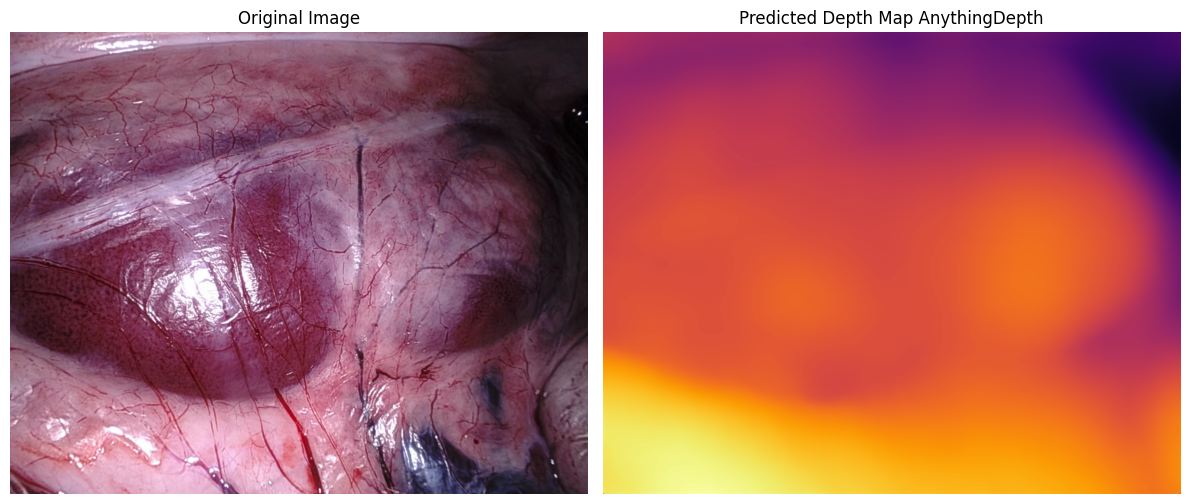

In [ ]:


# Convert the predicted depth to a NumPy array
depth = predicted_depth_da1.squeeze().cpu().numpy()

# Normalize the depth map for better visualization
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())

# Plot side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_normalized, cmap='inferno')
plt.title("Predicted Depth Map AnythingDepth")
plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
%%capture
!pip install opencv-python scikit-image tensorboard matplotlib tqdm timm==0.5.4

In [5]:

!git clone https://github.com/gangweiX/IGEV.git

Cloning into 'IGEV'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 375 (delta 123), reused 81 (delta 81), pack-reused 229 (from 2)
Receiving objects: 100% (375/375), 50.90 MiB | 18.48 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [7]:
!pip install -q gdown
import gdown

In [8]:
# Descargando el archivo kitti15.pth. Kitti15 is the pretrained weights with KITTI dataset.
file_id = "1VG47N7gPzkg-FIhge0XHtlOVHDVmMdek"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="/content/kitti15.pth", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1VG47N7gPzkg-FIhge0XHtlOVHDVmMdek
From (redirected): https://drive.google.com/uc?id=1VG47N7gPzkg-FIhge0XHtlOVHDVmMdek&confirm=t&uuid=771fd216-5f2f-4bfe-bf12-372bcf71bde7
To: /content/kitti15.pth
100%|██████████| 50.8M/50.8M [00:00<00:00, 94.1MB/s]


'/content/kitti15.pth'

In [27]:
# Usando las imagenes rectificadas de ejemplo usando el modelo IGEV++ with the pretained weights with KITTI Dataset
url = "/content/drive/MyDrive/Colab Notebooks/Semillero/PROYECTO_ENDOSCOPIA"
left_img = f"{url}/frame_00000_rectified_left.png"
right_img = f"{url}/frame_00000_rectified_right.png"
output_dir = "/content/IGEV/IGEV-Stereo/prueba_endoscopia"

!python demo_imgs.py --restore_ckpt '/content/kitti15.pth' -l="{left_img}" -r="{right_img}" --output_directory="{output_dir}"

Found 1 images. Saving files to /content/IGEV/IGEV-Stereo/prueba_endoscopia/
  0% 0/1 [00:00<?, ?it/s]/content/IGEV/IGEV-Stereo/core/igev_stereo.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
/content/IGEV/IGEV-Stereo/core/igev_stereo.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
/content/IGEV/IGEV-Stereo/core/update.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/content/IGEV/IGEV-Stereo/core/igev_stereo.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` i

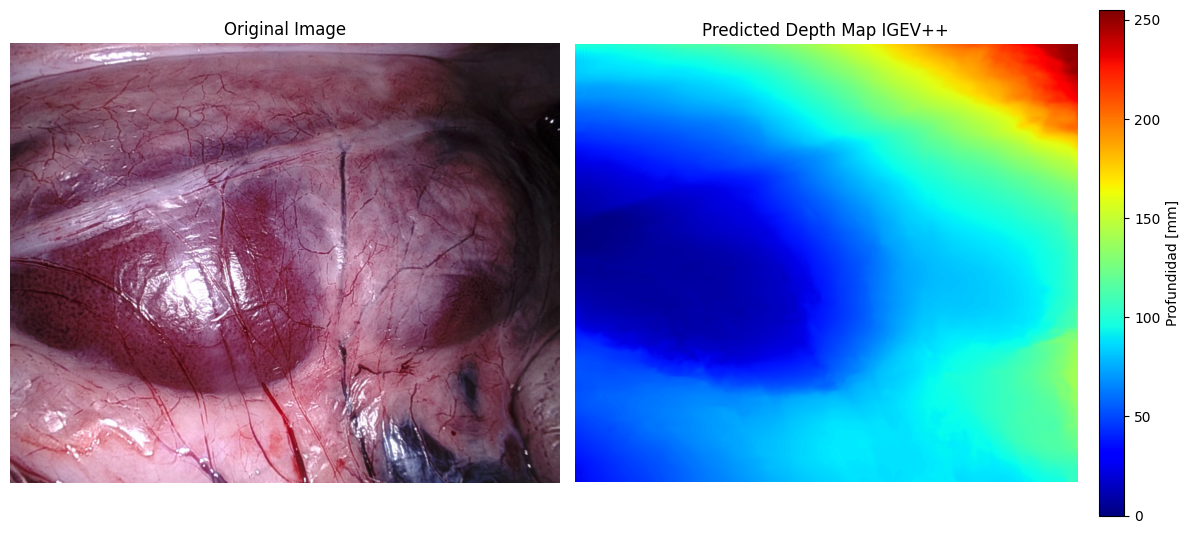

In [ ]:
# Cuantos milimetros esta la camara del objetivo Preguntar!!
DepthRecitifiedImages = cv2.imread(f"{output_dir}/PROYECTO_ENDOSCOPIA.png", cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Depth map
plt.subplot(1, 2, 2)
img_plot = plt.imshow(DepthRecitifiedImages, cmap='jet')
plt.title("Predicted Depth Map IGEV++")
plt.axis("off")

# Añadir barra de color
cbar = plt.colorbar(img_plot, fraction=0.046, pad=0.04)
cbar.set_label("Profundidad [mm]")

plt.tight_layout()
plt.show()

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [13]:
# Probar con imagenes no rectificadas el modelo IGEV++
keyframe_path = '/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/rgb.mp4'
out_path = "output"

extract_and_split_frames(keyframe_path, out_path)




Done. Extracted 197 frames to 'output/left' and 'output/right'.


In [14]:
# Probar con imagenes no rectificadas de mi dataset el 7, probrar con el keyframe_1

left_img = "/content/output/left/frame_00001.png"
right_img = "/content/output/right/frame_00001.png"
output_dir = "prueba_imagenes_no_rectificadas/"
%cd /content/IGEV/IGEV-Stereo/

!python demo_imgs.py --restore_ckpt '/content/kitti15.pth' -l="{left_img}" -r="{right_img}" --output_directory="{output_dir}"

/content/IGEV/IGEV-Stereo
Found 1 images. Saving files to prueba_imagenes_no_rectificadas/
  0% 0/1 [00:00<?, ?it/s]/content/IGEV/IGEV-Stereo/core/igev_stereo.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
/content/IGEV/IGEV-Stereo/core/igev_stereo.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
/content/IGEV/IGEV-Stereo/core/update.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/content/IGEV/IGEV-Stereo/core/igev_stereo.py:142: FutureWarning: `torch.cuda.amp.autoca

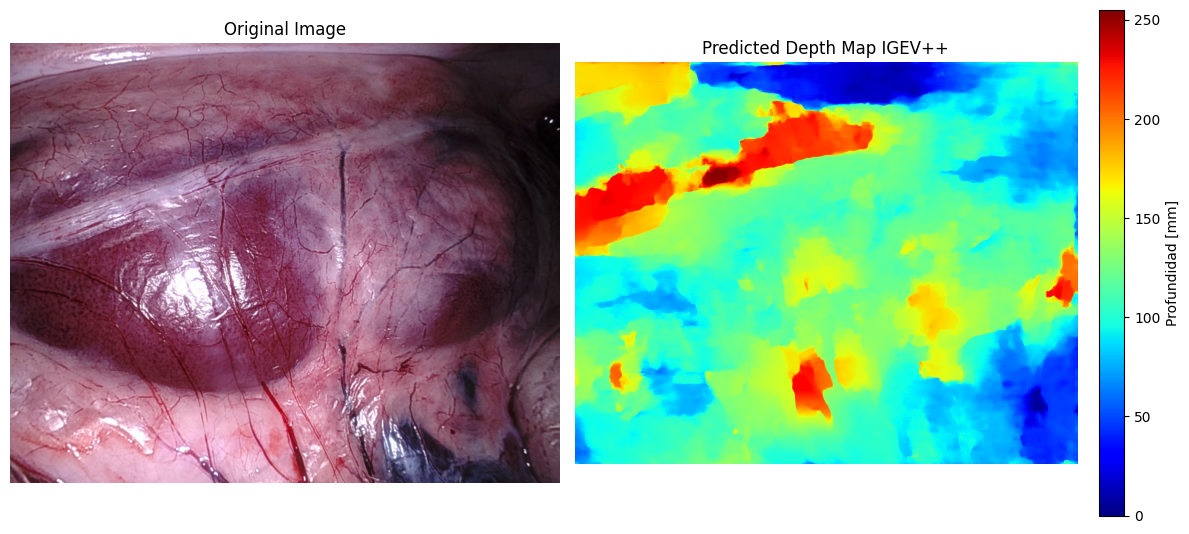

In [18]:
DepthRecitifiedImages = cv2.imread("/content/IGEV/IGEV-Stereo/prueba_imagenes_no_rectificadas/left.png", cv2.IMREAD_UNCHANGED)
image = Image.open("/content/output/left/frame_00001.png")

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Depth map
plt.subplot(1, 2, 2)
img_plot = plt.imshow(DepthRecitifiedImages, cmap='jet')
plt.title("Predicted Depth Map IGEV++")
plt.axis("off")

# Añadir barra de color
cbar = plt.colorbar(img_plot, fraction=0.046, pad=0.04)
cbar.set_label("Profundidad [mm]")

plt.tight_layout()
plt.show()

In [20]:
# Usando las imagenes rectificadas de ejemplo usando el modelo IGEV++ with the pretained weights with KITTI Dataset


left_img = "/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_7/keyframe_1/rectified_video_frame/left/frame_00000_rectified.png"
right_img = "/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_7/keyframe_1/rectified_video_frame/right/frame_00000_rectified.png"
output_dir = "prueba_imagenes_rectificadas/"
%cd /content/IGEV/IGEV-Stereo/

!python demo_imgs.py --restore_ckpt '/content/kitti15.pth' -l="{left_img}" -r="{right_img}" --output_directory="{output_dir}"

/content/IGEV/IGEV-Stereo
Found 1 images. Saving files to prueba_imagenes_rectificadas/
  0% 0/1 [00:00<?, ?it/s]/content/IGEV/IGEV-Stereo/core/igev_stereo.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
/content/IGEV/IGEV-Stereo/core/igev_stereo.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision, dtype=getattr(torch, self.args.precision_dtype, torch.float16)):
/content/IGEV/IGEV-Stereo/core/update.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/content/IGEV/IGEV-Stereo/core/igev_stereo.py:142: FutureWarning: `torch.cuda.amp.autocast(

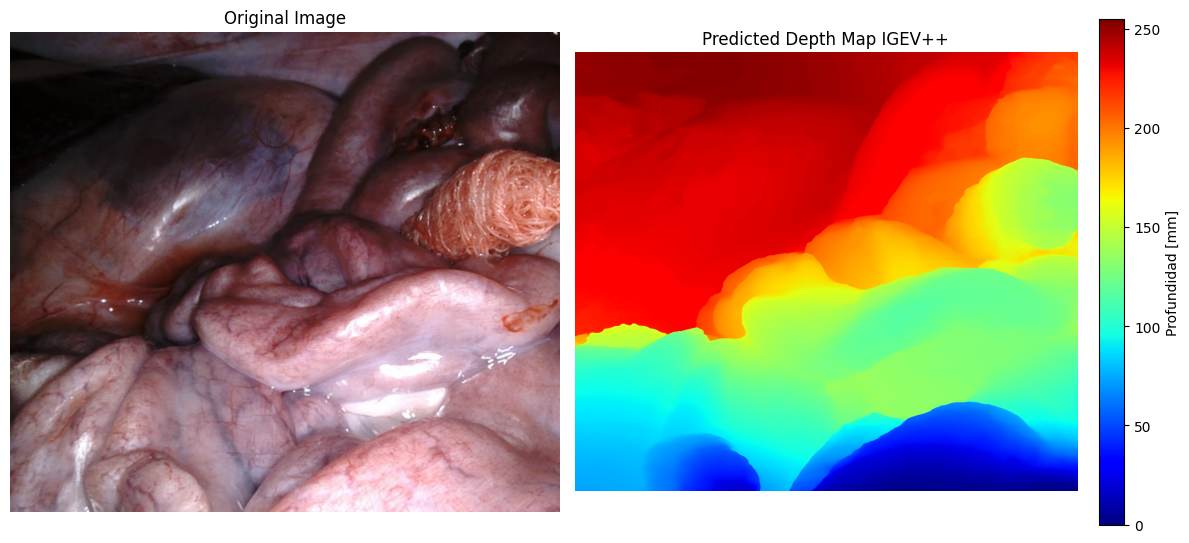

In [21]:
DepthRecitifiedImages = cv2.imread("/content/IGEV/IGEV-Stereo/prueba_imagenes_rectificadas/left.png", cv2.IMREAD_UNCHANGED)
image = Image.open(left_img)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Depth map
plt.subplot(1, 2, 2)
img_plot = plt.imshow(DepthRecitifiedImages, cmap='jet')
plt.title("Predicted Depth Map IGEV++")
plt.axis("off")

# Añadir barra de color
cbar = plt.colorbar(img_plot, fraction=0.046, pad=0.04)
cbar.set_label("Profundidad [mm]")

plt.tight_layout()
plt.show()

In [ ]:
# Kitti.py
!pip uninstall utils -y


Found existing installation: utils 1.0.2
Uninstalling utils-1.0.2:
  Successfully uninstalled utils-1.0.2


In [ ]:
# Kitti.py

import os
import random
import torch
import numpy as np
# Hacer el gitclone importante!
import sys
%cd /content/IGEV/IGEV-Stereo/core/utils
# Add the core directory to sys.path to allow importing utils
sys.path.insert(0, '/content/IGEV/IGEV-Stereo/core/utils')



import frame_utils

from loguru import logger
from torch.utils import data
from torchvision.transforms import v2 as transforms

from torch.utils.data.distributed import DistributedSampler

/content/IGEV/IGEV-Stereo/core/utils


In [ ]:
# Kitti.py

#data.Dataset pytorch dataset
class KittiDepthCompletion(data.Dataset):
    def __init__(self, data_path, crop_size, training=True): #data_path where the dataset is stored #crop_size tuple(height,width) size to crop the images #training True to train, False to evaluate

        mode = 'train' if training else 'val' #It determines whether to load train or val dataset
        split_path = os.path.join(data_path, mode) #split_path "data_path/mode"

        self.crop_size = crop_size #Instance crop_size rgbleft rgbright sparsefile ("depthmaps") gt_file ("Ground Truth")
        self.rgb_left_filenames, self.rgb_right_filenames, self.sparse_filenames, self.gt_filenames = data_utils.get_kitti_files(split_path)
        self.training = training

        # Transforms to the dataset train

        self.transform_train = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=False)
        ])

        # Transforms to the dataset val

        self.transform_val = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=False)
        ])

        self.normalize_val = transforms.Compose([transforms.ToImage(),transforms.ToDtype(torch.float32, scale=True)])

    def __len__(self): #Number of depth maps
        return len(self.sparse_filenames)

    def __getitem__(self, idx): #getitem from an index, example 0000 gets the left right image

        rgb_left = frame_utils.read_rgb(self.rgb_left_filenames[idx])  #frame_utils a class with a method to read rgb image
        rgb_right = frame_utils.read_rgb(self.rgb_right_filenames[idx])
        sparse_disp = frame_utils.read_depth(self.sparse_filenames[idx])
        gt_disp = frame_utils.read_depth(self.gt_filenames[idx])

        width = gt_disp.shape[1]

        rgb_left_crop = frame_utils.crop_bottom_center(rgb_left, self.crop_size)  #frame_utils to crop. no idea why
        rgb_right_crop = frame_utils.crop_bottom_center(rgb_right, self.crop_size)
        sparse_crop = frame_utils.crop_bottom_center(sparse_disp, self.crop_size)
        gt_crop = frame_utils.crop_bottom_center(gt_disp, self.crop_size)

        if self.training: #Si se entrena
            rgb_left_clean = self.transform_train(rgb_left_crop) #Applies the transform_train pipeline
            rgb_right_clean = self.transform_train(rgb_right_crop)#Applies the transform_train pipeline
            sparse = self.transform_train(sparse_crop)
            gt = self.transform_train(gt_crop)

            rgb_left_aug = rgb_left_clean.clone() #Copy of the transform image
            rgb_left_aug = (rgb_left_aug - rgb_left_aug.min()) / (rgb_left_aug.max() - rgb_left_aug.min()) #This Augmented image is normalized between [0,1]

            if random.random() < 0.5: #Data augmentation helps increase the diversity of the training data and can improve the model's generalization ability

                brightness = np.random.uniform(0.6, 1.2)
                contrast = np.random.uniform(0.6, 1.2)
                saturation = np.random.uniform(0.6, 1.2)
                #hue = np.random.uniform(-0.1, 0.1)

                rgb_left_aug = transforms.functional.adjust_brightness(rgb_left_aug, brightness)
                rgb_left_aug = transforms.functional.adjust_contrast(rgb_left_aug, contrast)
                rgb_left_aug = transforms.functional.adjust_saturation(rgb_left_aug, saturation)
                #rgb_left_aug = transforms.functional.adjust_hue(rgb_left_aug, hue)

            rgb_left_aug = transforms.functional.normalize(rgb_left_aug, (0.485, 0.456, 0.406),
                               (0.229, 0.224, 0.225), inplace=True) # This normalized the agumented image using the mean and SD of the imageNet dataset. Standat practice when using pre-trained models

            #rgb_left_aug = transforms.functional.rotate(
            #    rgb_left_aug, angle=degree, interpolation=transforms.InterpolationMode.BILINEAR
            #)
            #flip = np.random.uniform(0.0, 1.0)
            #if flip > 0.5:
            #    rgb_left_aug = transforms.functional.hflip(rgb_left_aug)
            #    sparse = transforms.functional.hflip(sparse)
            #    gt = transforms.functional.hflip(gt)

            #Another data augmentation techquines

            return rgb_left_aug, rgb_left_clean, rgb_right_clean, sparse, gt, width

        else: # If the model is evaluating
            rgb_left_clean = self.transform_val(rgb_left_crop)
            rgb_right_clean = self.transform_val(rgb_right_crop)

            sparse = self.transform_val(sparse_crop)
            gt = self.transform_val(gt_crop)

            rgb_left_aug = rgb_left_clean.clone()
            rgb_left_aug = (rgb_left_aug - rgb_left_aug.min()) / (rgb_left_aug.max() - rgb_left_aug.min())
            rgb_left_aug = transforms.functional.normalize(rgb_left_aug, (0.485, 0.456, 0.406),
                               (0.229, 0.224, 0.225), inplace=True)
            #We apply a normalization between [0,1] and then apply a normal distribution same SD and Mean from imageNet
            return rgb_left_aug, rgb_left_clean, rgb_right_clean, sparse, gt, width

def get_dataloader(args, train=True, distributed=False, rank=0, world_size=1):
    #Dataloader batching and suffle data
    #args arguments or configuration settings for the data loading process
    #train training false evaluation
    #distributed false whether the data loading should be done un a distributed manner across multiple proccesing units. This is often used in large-scale training scenarios
    #rank 0 represents the rank of the current process in a distributed setting. It's used to ensure that each process loads a unique subset of the data
    #world_size 1 total number of processes participating in a distributed training setup


    if not train:
        args.batch_size = 1 #validation to evaluate samples individually
        args.crop_size = (256, 1216) #crop

    dataset = KittiDepthCompletion(args.data_path, args.crop_size, train) #dataset instance
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=train) if distributed else None
    #The DistributedSampler shuffles the data by performing a random permutation before subsampling for each process
    #torch.utils.data.distributed.DistributedSampler
    #data.DataLoader torch library
    #
    dataloader = data.DataLoader(
        dataset,
        batch_size=args.batch_size, #This specifies the total number of processes participating in the distributed training.
        shuffle=(sampler is None and train), #Data us suffled during training to improve model generalization
        num_workers=args.num_workers, #number of subprocess to use for data loading
        pin_memory=True, #Copies tensors to the GPU's pinned memory
        sampler=sampler, #
        drop_last=train #Drops the last incomplete batch if the total number of samples is not divisible bt the batchsize
    )

    if rank == 0:
        logger.info(f"Loading {len(dataset)} images from KITTI Depth Completion dataset.")
        if distributed:
            logger.info(f"Using DistributedSampler with {world_size} processes.")

    return dataloader, len(dataset) #return dataloader and dataset

#Data Loading: Reading image and depth files.
#Preprocessing: Cropping and converting to PyTorch tensors.
#Data Augmentation: Applying common transforms like color jitter (and optionally rotation/flipping) during training to improve model generalization.
#Batching: Grouping individual samples into batches for efficient model training.
#Distributed Training: Support for training across multiple GPUs/machines using DistributedSampler.

In [ ]:
import cv2
import os
import sys

# Extract and splot frames of videos using the structure of the folder from the drive

def extract_and_split_frames(input_path, img_ext='png'):
    # Verificar video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: cannot open video '{input_path}'")
        return

    # Dimensiones del video
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    half_h = height // 2

    # Extraer dataset y keyframe desde la ruta
    parts = input_path.split('/')
    try:
        dataset_idx = parts.index('train') + 1
        dataset_name = parts[dataset_idx]
        keyframe_name = parts[dataset_idx + 1]
    except (ValueError, IndexError):
        print("Error: no se pudo identificar dataset_x o keyframe_x en la ruta.")
        return

    # Crear rutas de salida
    root_dir = os.path.join('content','PROYECTO_ENDOSCOPIA','train')  # /content/PROYECTO_ENDOSCOPIA/train
    base_out = os.path.join(root_dir, dataset_name, keyframe_name, 'data')
    left_dir = os.path.join(base_out, 'left_image')
    right_dir = os.path.join(base_out, 'right_image')
    os.makedirs(left_dir, exist_ok=True)
    os.makedirs(right_dir, exist_ok=True)

    # Procesamiento frame a frame
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        top    = frame[0:half_h, 0:width]
        bottom = frame[half_h:height, 0:width]

        left_path  = os.path.join(left_dir,  f"frame_{frame_idx:05d}_rectified_left.{img_ext}")
        right_path = os.path.join(right_dir, f"frame_{frame_idx:05d}_rectified_right.{img_ext}")

        cv2.imwrite(left_path,  top)
        cv2.imwrite(right_path, bottom)

        frame_idx += 1

    cap.release()
    print(f"[{dataset_name}/{keyframe_name}] Done. Extracted {frame_idx} frames.")

In [ ]:
video_path = '/content/drive/MyDrive/Colab Notebooks/Semillero/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/rgb.mp4'
extract_and_split_frames(video_path)


[dataset_1/keyframe_1] Done. Extracted 197 frames.


In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms.functional as TF

def read_image(image_path):
    """Reads an image from the given path and returns a PIL Image."""
    return Image.open(image_path).convert("RGB")

def get_scared_file_pairs(root_path):
    """
    Scans the SCARED dataset directory and returns lists of corresponding left and right image paths.
    """
    left_images = []
    right_images = []

    for dataset_folder in sorted(os.listdir(root_path)):
        print(dataset_folder)
        dataset_path = os.path.join(root_path, dataset_folder)
        print(dataset_path)
        #if not os.path.isdir(dataset_path):
         #   print('Not found')
          #  continue
        for keyframe_folder in sorted(os.listdir(dataset_path)):
            print("keyframe " +keyframe_folder)
            keyframe_path = os.path.join(dataset_path, keyframe_folder, 'data')
            print(keyframe_path)
            #if not os.path.isdir(keyframe_path):
             #   print('Not found')
              #  continue

            left_dir = os.path.join(keyframe_path, 'left_image')
            right_dir = os.path.join(keyframe_path, 'right_image')
            print(left_dir)


            for filename in sorted(os.listdir(left_dir)):
                  left_path = os.path.join(left_dir, filename)
                  left_images.append(left_path)
            for filename in sorted(os.listdir(right_dir)):
                  right_path = os.path.join(right_dir, filename)
                  right_images.append(right_path)

    return left_images, right_images


In [ ]:
# SCARED_IGEV.py
#Cargar las imagenes rectificadas para ser procesadas por el modelo IGEV++
#The following code is going to handle Data Loading, Data Pre-Procesing for Traing or Evaluation and Data Augmentation.

import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
#import scared_utils

class SCARED_IGEV(Dataset):
    def __init__(self, root_path, training=True):
        """
        Args:
            root_path (str): Root path to the SCARED dataset.
            training (bool): Whether the dataset is for training or evaluation.
        """
        self.training = training
        self.left_paths, self.right_paths = get_scared_file_pairs(root_path)

        # Define transforms (optional: normalization like ImageNet for pretrained models)
        self.transform_base = transforms.Compose([
            transforms.ToTensor()
        ])

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.left_paths)

    def __getitem__(self, idx):
        left_img = read_image(self.left_paths[idx])
        right_img = read_image(self.right_paths[idx])

        # Apply base transforms
        left_tensor = self.transform_base(left_img)
        right_tensor = self.transform_base(right_img)

        if self.training:
            # Optionally: Apply data augmentation (color jitter etc.)
            left_aug = left_tensor.clone()
            left_aug = (left_aug - left_aug.min()) / (left_aug.max() - left_aug.min())
            left_aug = self.normalize(left_aug)

            return left_aug, left_tensor, right_tensor
        else:
            left_aug = left_tensor.clone()
            left_aug = (left_aug - left_aug.min()) / (left_aug.max() - left_aug.min())
            left_aug = self.normalize(left_aug)

            return left_aug, left_tensor, right_tensor


In [ ]:
from torch.utils.data import DataLoader

def get_scared_dataloader(args, train=True):
    dataset = SCARED_IGEV(args.data_path, training=train)

    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=args.shuffle,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=train
    )

    return dataloader, len(dataset)

In [ ]:
# An example with non rectified images

root_path = '/content/content/PROYECTO_ENDOSCOPIA/train'

left_img, right_img = get_scared_file_pairs(root_path)

print(len(left_img))



dataset_1
/content/content/PROYECTO_ENDOSCOPIA/train/dataset_1
keyframe keyframe_1
/content/content/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data
/content/content/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/left_image
197


In [ ]:
class Args:
    data_path = '/content/content/PROYECTO_ENDOSCOPIA/train/'
    batch_size = 10
    shuffle = True
    num_workers = 0

args = Args()
dataloader, dataset_size = get_scared_dataloader(args, train=True)

dataset_1
/content/content/PROYECTO_ENDOSCOPIA/train/dataset_1
keyframe keyframe_1
/content/content/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data
/content/content/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/data/left_image


In [ ]:
dataloader

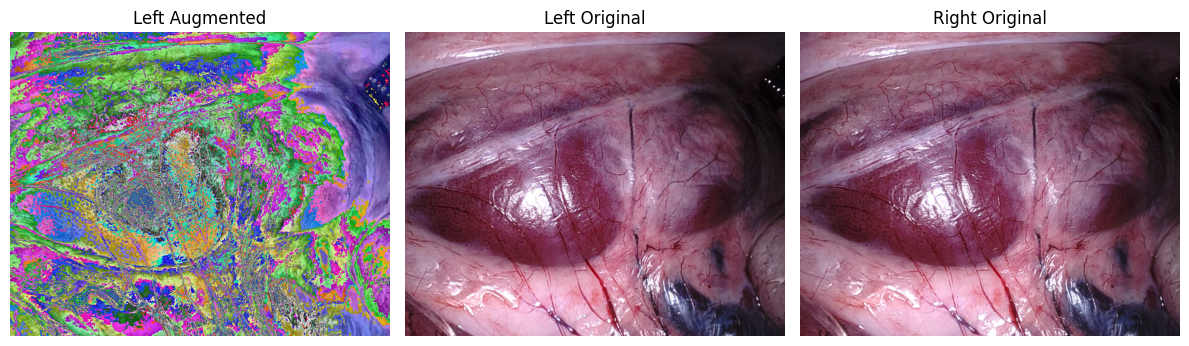

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

data_batch = next(iter(dataloader))
left_aug, left_tensor, right_tensor = data_batch  # Each is a tensor of shape [B, C, H, W]

# Pick the first sample in the batch
idx = 0
left_aug_img = F.to_pil_image(left_aug[idx].cpu())
left_orig_img = F.to_pil_image(left_tensor[idx].cpu())
right_orig_img = F.to_pil_image(right_tensor[idx].cpu())

# Plot the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(left_aug_img)
plt.title('Left Augmented')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(left_orig_img)
plt.title('Left Original')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(right_orig_img)
plt.title('Right Original')
plt.axis('off')

plt.tight_layout()
plt.show()